In [41]:
!pip install tensorflow 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached protobuf-4.25.5-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
Using cached keras-3.7.0-py3-none-any.whl (1.2 MB)
Using cached protobuf-4.25.5-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl (6.6 MB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
  Attempting uninstall: tensorbo

In [42]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is configured and ready to use.")
    except RuntimeError as e:
        print(f"Error configuring GPU: {e}")
else:
    print("No GPU found. Using CPU instead.")

# Step 2: Verify GPU Availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:")
!nvidia-smi

# Step 3: Install TensorFlow GPU (Optional in Kaggle, typically pre-installed)
!pip install tensorflow-gpu==2.10.1 --quiet


GPU is configured and ready to use.
Num GPUs Available: 1
GPU Details:
Mon Dec 23 20:07:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             36W /  250W |   15795MiB /  16384MiB |      0%      Default |
|                                         |                        | 

In [43]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print("\nModel training complete.")
print("Device used:", "GPU" if tf.test.is_gpu_available() else "CPU")


/kaggle/input/population-flows/finaldataframe.csv

Model training complete.
Device used: GPU


In [44]:
data = pd.read_csv('/kaggle/input/population-flows/finaldataframe.csv')

In [6]:
display(data)

,Unnamed: 0,geoid_o,geoid_d,lng_o,lat_o,lng_d,lat_d,date,visitor_flows,pop_flows,...,police_station_destination,fire_station_destination,land_use_commercial_destination,land_use_industrial_destination,land_use_retail_destination,land_use_residential_destination,land_use_natural_destination,year,origin_population,destination_population
0,0,1,2,-86.844521,32.756880,-151.593422,63.742989,2019-01-01,17,200.0,...,74,142,481,878,261,1525,686,2019,4907965,733603
1,1,1,4,-86.844521,32.756880,-111.664460,34.293095,2019-01-01,330,3886.0,...,192,529,2879,1864,3047,17995,128,2019,4907965,7291843
2,2,1,5,-86.844521,32.756880,-92.439237,34.899772,2019-01-01,553,6512.0,...,457,1387,471,1419,569,1576,1790,2019,4907965,3020985
3,3,1,6,-86.844521,32.756880,-119.663846,37.215308,2019-01-01,1267,14921.0,...,836,2643,23135,12946,11730,212380,6494,2019,4907965,39437610
4,4,1,8,-86.844521,32.756880,-105.547821,38.998532,2019-01-01,1179,13885.0,...,260,677,2317,8550,1901,12941,1333,2019,4907965,5758486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557482,1557482,56,50,-107.551394,42.999537,-72.662630,44.075248,2021-04-15,6,126.0,...,42,302,275,210,151,1998,557,2021,5879978,579548
1557483,1557483,56,51,-107.551394,42.999537,-78.666349,37.510873,2021-04-15,25,527.0,...,402,1482,3196,3395,3706,19785,2392,2021,5879978,647093
1557484,1557484,56,53,-107.551394,42.999537,-120.592900,47.411639,2021-04-15,48,1013.0,...,305,989,6582,4394,4431,29419,5748,2021,5879978,8657348
1557485,1557485,56,54,-107.551394,42.999537,-80.613707,38.642567,2021-04-15,15,316.0,...,84,199,593,1211,254,2944,397,2021,5879978,7741433


In [45]:
X = data[[ 
 'geoid_o',
 'geoid_d','lng_o','lng_d','lat_o','lat_d',
 'origin_GDP_millions_dollars',
 'destination_GDP_millions_dollars',
 'distance_km',
 'origin_unemployment',
 'destination_unemployment',
 'origin_income',
 'destination_income',
 'public_transport_origin',
 'road_network_residential_origin',
 'road_network_main_origin',
 'road_network_secondary_origin',
 'retail_supermarket_origin',
 'retail_department_store_origin',
 'retail_mall_origin',
 'education_origin',
 'police_station_origin',
 'fire_station_origin',
 'land_use_commercial_origin',
 'land_use_industrial_origin',
 'land_use_retail_origin',
 'land_use_residential_origin',
 'land_use_natural_origin',
 'public_transport_destination',
 'road_network_residential_destination',
 'road_network_main_destination',
 'road_network_secondary_destination',
 'retail_supermarket_destination',
 'retail_department_store_destination',
 'retail_mall_destination',
 'education_destination',
 'police_station_destination',
 'fire_station_destination',
 'land_use_commercial_destination',
 'land_use_industrial_destination',
 'land_use_retail_destination',
 'land_use_residential_destination',
 'land_use_natural_destination',
 'origin_population',
 'destination_population']]

y = data[['pop_flows']]
y = y.squeeze()
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False, random_state=42)
  
print(X_train.shape)
print(y_train.shape)

num = [
 'origin_GDP_millions_dollars',
 'destination_GDP_millions_dollars',
 'distance_km',
 'origin_unemployment',
 'destination_unemployment',
 'origin_income',
 'destination_income',
 'public_transport_origin',
 'road_network_residential_origin',
 'road_network_main_origin',
 'road_network_secondary_origin',
 'retail_supermarket_origin',
 'retail_department_store_origin',
 'retail_mall_origin',
 'education_origin',
 'police_station_origin',
 'fire_station_origin',
 'land_use_commercial_origin',
 'land_use_industrial_origin',
 'land_use_retail_origin',
 'land_use_residential_origin',
 'land_use_natural_origin',
 'public_transport_destination',
 'road_network_residential_destination',
 'road_network_main_destination',
 'road_network_secondary_destination',
 'retail_supermarket_destination',
 'retail_department_store_destination',
 'retail_mall_destination',
 'education_destination',
 'police_station_destination',
 'fire_station_destination',
 'land_use_commercial_destination',
 'land_use_industrial_destination',
 'land_use_retail_destination',
 'land_use_residential_destination',
 'land_use_natural_destination',
 'origin_population',
 'destination_population']

classing = ['geoid_o', 'geoid_d']


(934491, 45)
(934491,)


In [61]:
display(X_train)

,geoid_o,geoid_d,origin_GDP_millions_dollars,destination_GDP_millions_dollars,distance_km,origin_unemployment,destination_unemployment,origin_income,destination_income,public_transport_origin,...,education_destination,police_station_destination,fire_station_destination,land_use_commercial_destination,land_use_industrial_destination,land_use_retail_destination,land_use_residential_destination,land_use_natural_destination,origin_population,destination_population
0,1,2,222527.4,52004.2,5559.795327,3.2,5.6,70090.35,91268.57,2103,...,504,74,142,481,878,261,1525,686,4907965,733603
1,1,4,222527.4,352764.7,2306.243061,3.2,4.8,70090.35,87823.18,2103,...,2710,192,529,2879,1864,3047,17995,128,4907965,7291843
2,1,5,222527.4,126243.8,569.719916,3.2,3.5,70090.35,68079.14,2103,...,2183,457,1387,471,1419,569,1576,1790,4907965,3020985
3,1,6,222527.4,2901258.9,3021.643753,3.2,4.1,70090.35,102375.47,2103,...,15510,836,2643,23135,12946,11730,212380,6494,4907965,39437610
4,1,8,222527.4,373512.4,1821.042320,3.2,2.7,70090.35,98129.07,2103,...,2859,260,677,2317,8550,1901,12941,1333,4907965,5758486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934486,9,16,265209.2,82852.5,3396.077579,8.0,5.5,117303.22,91721.86,863,...,995,54,158,1587,685,1019,7128,744,3577586,1849339
934487,9,17,265209.2,833321.9,1391.033784,8.0,9.3,117303.22,103958.50,863,...,6626,494,1005,6653,5786,9312,37524,2850,3577586,12790357
934488,9,18,265209.2,367070.0,1157.254453,8.0,7.3,117303.22,87139.09,863,...,2789,184,568,2726,2903,2215,21695,2065,3577586,6789098
934489,9,19,265209.2,188044.3,1721.492348,8.0,5.2,117303.22,86536.71,863,...,2320,364,625,2291,2919,1040,14552,2838,3577586,3190904


In [36]:
traincoord = data[['lng_o', 'lat_o', 'lng_d', 'lat_d']]
traincoord = traincoord[:934491]
display (traincoord)


,lng_o,lat_o,lng_d,lat_d
0,-86.844521,32.756880,-151.593422,63.742989
1,-86.844521,32.756880,-111.664460,34.293095
2,-86.844521,32.756880,-92.439237,34.899772
3,-86.844521,32.756880,-119.663846,37.215308
4,-86.844521,32.756880,-105.547821,38.998532
...,...,...,...,...
934486,-72.738258,41.575164,-114.659414,44.389055
934487,-72.738258,41.575164,-89.148639,40.124201
934488,-72.738258,41.575164,-86.281838,39.919870
934489,-72.738258,41.575164,-93.500090,42.074648


In [37]:
display(X_test)

,geoid_o,geoid_d,lng_o,lng_d,lat_o,lat_d,origin_GDP_millions_dollars,destination_GDP_millions_dollars,distance_km,origin_unemployment,...,education_destination,police_station_destination,fire_station_destination,land_use_commercial_destination,land_use_industrial_destination,land_use_retail_destination,land_use_residential_destination,land_use_natural_destination,origin_population,destination_population
1245989,13,1,-83.427140,-86.844521,32.638617,32.756880,615816.7,227213.6,320.703983,6.5,...,2734,146,476,947,3395,571,5029,1165,10732390,5031864
1245990,13,2,-83.427140,-151.593422,32.638617,63.742989,615816.7,50702.9,5739.157055,6.5,...,504,74,142,481,878,261,1525,686,10732390,732964
1245991,13,4,-83.427140,-111.664460,32.638617,34.293095,615816.7,376719.4,2622.918604,6.5,...,2710,192,529,2879,1864,3047,17995,128,10732390,7186683
1245992,13,5,-83.427140,-92.439237,32.638617,34.899772,615816.7,130987.9,871.309153,6.5,...,2183,457,1387,471,1419,569,1576,1790,10732390,3014348
1245993,13,6,-83.427140,-119.663846,32.638617,37.215308,615816.7,3015659.5,3329.116992,6.5,...,15510,836,2643,23135,12946,11730,212380,6494,10732390,39503200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557482,56,50,-107.551394,-72.662630,42.999537,44.075248,36937.7,33657.2,2801.307560,4.5,...,854,42,302,275,210,151,1998,557,5879978,579548
1557483,56,51,-107.551394,-78.666349,42.999537,37.510873,36937.7,559682.2,2518.263248,4.5,...,3550,402,1482,3196,3395,3706,19785,2392,5879978,647093
1557484,56,53,-107.551394,-120.592900,42.999537,47.411639,36937.7,628058.5,1133.952574,4.5,...,4223,305,989,6582,4394,4431,29419,5748,5879978,8657348
1557485,56,54,-107.551394,-80.613707,42.999537,38.642567,36937.7,75214.2,2312.869260,4.5,...,1189,84,199,593,1211,254,2944,397,5879978,7741433


In [12]:
testcoord = data[['lng_o', 'lat_o', 'lng_d', 'lat_d']]
testcoord = testcoord[1245989:1557487]


In [11]:
display(X_test)

,geoid_o,geoid_d,origin_GDP_millions_dollars,destination_GDP_millions_dollars,distance_km,origin_unemployment,destination_unemployment,origin_income,destination_income,public_transport_origin,...,education_destination,police_station_destination,fire_station_destination,land_use_commercial_destination,land_use_industrial_destination,land_use_retail_destination,land_use_residential_destination,land_use_natural_destination,origin_population,destination_population
1245989,13,1,615816.7,227213.6,320.703983,6.5,6.4,84224.69,78871.29,1324,...,2734,146,476,947,3395,571,5029,1165,10732390,5031864
1245990,13,2,615816.7,50702.9,5739.157055,6.5,8.3,84224.69,100086.45,1324,...,504,74,142,481,878,261,1525,686,10732390,732964
1245991,13,4,615816.7,376719.4,2622.918604,6.5,7.8,84224.69,96364.72,1324,...,2710,192,529,2879,1864,3047,17995,128,10732390,7186683
1245992,13,5,615816.7,130987.9,871.309153,6.5,6.2,84224.69,77637.36,1324,...,2183,457,1387,471,1419,569,1576,1790,10732390,3014348
1245993,13,6,615816.7,3015659.5,3329.116992,6.5,10.1,84224.69,111632.93,1324,...,15510,836,2643,23135,12946,11730,212380,6494,10732390,39503200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557482,56,50,36937.7,33657.2,2801.307560,4.5,3.6,96890.19,101564.10,395,...,854,42,302,275,210,151,1998,557,5879978,579548
1557483,56,51,36937.7,559682.2,2518.263248,4.5,3.9,96890.19,121484.90,395,...,3550,402,1482,3196,3395,3706,19785,2392,5879978,647093
1557484,56,53,36937.7,628058.5,1133.952574,4.5,5.2,96890.19,128690.61,395,...,4223,305,989,6582,4394,4431,29419,5748,5879978,8657348
1557485,56,54,36937.7,75214.2,2312.869260,4.5,5.1,96890.19,75362.10,395,...,1189,84,199,593,1211,254,2944,397,5879978,7741433


In [12]:
display(testcoord)

,lng_o,lat_o,lng_d,lat_d
1245989,-83.427140,32.638617,-86.844521,32.756880
1245990,-83.427140,32.638617,-151.593422,63.742989
1245991,-83.427140,32.638617,-111.664460,34.293095
1245992,-83.427140,32.638617,-92.439237,34.899772
1245993,-83.427140,32.638617,-119.663846,37.215308
...,...,...,...,...
1557482,-107.551394,42.999537,-72.662630,44.075248
1557483,-107.551394,42.999537,-78.666349,37.510873
1557484,-107.551394,42.999537,-120.592900,47.411639
1557485,-107.551394,42.999537,-80.613707,38.642567


In [46]:
input_shape = (45,)


In [47]:
from tensorflow.keras.layers import Dense, Dropout


In [74]:
mlpmodel = Sequential()
mlpmodel.add(tf.keras.layers.Normalization(input_shape=input_shape))
mlpmodel.add(Dense(128, kernel_initializer='normal', activation='relu'))
mlpmodel.add(Dense(256, kernel_initializer='normal', activation='relu'))
mlpmodel.add(Dropout(0.2))
mlpmodel.add(Dense(256, kernel_initializer='normal', activation='relu'))
mlpmodel.add(Dense(256, kernel_initializer='normal', activation='relu'))
mlpmodel.add(Dropout(0.2))
mlpmodel.add(Dense(256, kernel_initializer='normal', activation='relu'))
mlpmodel.add(Dense(256, kernel_initializer='normal', activation='relu'))
mlpmodel.add(Dropout(0.2))
mlpmodel.add(Dense(32,kernel_initializer='normal',activation='linear'))
mlpmodel.add(Dense(1))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',            # Monitor the validation loss
    patience=10,                   # Number of epochs with no improvement before stopping
    restore_best_weights=True      # Restore the model weights from the best epoch
)

ModuleNotFoundError: No module named 'tensorflow.keras.callbacks'

In [75]:

mlpmodel.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
mlpmodel.fit(X_train, y_train, epochs=250, batch_size=64, verbose=1, validation_split=0.2)

Epoch 1/250
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 13362.7598 - mean_absolute_error: 13362.7598 - val_loss: 12294.2305 - val_mean_absolute_error: 12294.2305
Epoch 2/250
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 12188.4609 - mean_absolute_error: 12188.4609 - val_loss: 12308.6592 - val_mean_absolute_error: 12308.6592
Epoch 3/250
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 11621.8037 - mean_absolute_error: 11621.8037 - val_loss: 10555.1621 - val_mean_absolute_error: 10555.1621
Epoch 4/250
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 10951.0820 - mean_absolute_error: 10951.0820 - val_loss: 9978.7559 - val_mean_absolute_error: 9978.7559
Epoch 5/250
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 10342.7754 - mean_absolute_error: 10342.7754 - val_loss: 8634.7451 - val_mean_absolute_error: 8634.7451
Epoch 6/250
11682/11682 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 9708.9688 - mean_absolute_error: 9708.9688 - val_loss: 9179.2891 - val_mean_ab

KeyboardInterrupt: 

In [76]:

from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
y_pred = mlpmodel.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")


9735/9735 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
R-squared: 0.6816193597954052


In [77]:
mlpmodel.evaluate(X_test, y_test)

9735/9735 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 5365.4941 - mean_absolute_error: 5365.4941


[6397.13330078125, 6397.13330078125]

In [78]:
mlpmodel.evaluate(X_train, y_train)

29203/29203 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - loss: 5023.6743 - mean_absolute_error: 5023.6743


[6265.03857421875, 6265.03857421875]

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(mlpmodel, X_test, y_test, n_repeats=10, random_state=42)

# Display feature importances
for i in range(len(result.importances_mean)):
    print(f"Feature {i}: {result.importances_mean[i]:.4f}")


In [78]:
rfmodel.predict(X_test)

NameError: name 'rfmodel' is not defined

In [ ]:
print(X_train.columns)

In [80]:
num = ['origin_GDP_millions_dollars' , 'destination_GDP_millions_dollars', 'distance_km' ,'destination_income', 'origin_income', 'destination_unemployment','origin_unemployment', 'public_transport_origin',
       'road_network_residential_origin', 'road_network_main_origin',
       'road_network_secondary_origin', 'retail_supermarket_origin',
       'retail_department_store_origin', 'retail_mall_origin',
       'education_origin', 'police_station_origin', 'fire_station_origin',
       'land_use_commercial_origin', 'land_use_industrial_origin',
       'land_use_retail_origin', 'land_use_residential_origin',
       'land_use_natural_origin', 'public_transport_destination',
       'road_network_residential_destination', 'road_network_main_destination',
       'road_network_secondary_destination', 'retail_supermarket_destination',
       'retail_department_store_destination', 'retail_mall_destination',
       'education_destination', 'police_station_destination',
       'fire_station_destination', 'land_use_commercial_destination',
       'land_use_industrial_destination', 'land_use_retail_destination',
       'land_use_residential_destination', 'land_use_natural_destination',
       'origin_population', 'destination_population']
classing = ['geoid_o', 'geoid_d']
class GeoIDEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder_origin = LabelEncoder()
        self.encoder_destination = LabelEncoder()
    
    def fit(self, X, y=None):
        # Fit label encoders to geoid columns
        print("Fitting GeoIDEncoder with columns:", X.columns)
        self.encoder_origin.fit(X['geoid_o'])
        self.encoder_destination.fit(X['geoid_d'])
        return self
    
    def transform(self, X):
        # Transform geoid columns using label encoders
        print("Transforming GeoID columns:", X.columns)
        X_transformed = X.copy()
        X_transformed['geoid_o'] = self.encoder_origin.transform(X_transformed['geoid_o'])
        X_transformed['geoid_d'] = self.encoder_destination.transform(X_transformed['geoid_d'])
        return X_transformed

In [140]:
from sklearn.metrics import mean_squared_error, r2_score

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num),
        ('geoid', GeoIDEncoder(), ['geoid_o', 'geoid_d']),  # Apply GeoIDEncoder to origin and destination
    ]
)

rfmodel = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200))
])

rfmodel.fit(X_train, y_train)

y_pred = rfmodel.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")


Fitting GeoIDEncoder with columns: Index(['geoid_o', 'geoid_d'], dtype='object')
Transforming GeoID columns: Index(['geoid_o', 'geoid_d'], dtype='object')
Transforming GeoID columns: Index(['geoid_o', 'geoid_d'], dtype='object')
RMSE: 22641.221985334985
R-squared: 0.6970091723906022


In [141]:
y_pred = rfmodel.predict(X_train)
r_squared = r2_score(y_train, y_pred)
print(f"R-squared: {r_squared}")


Transforming GeoID columns: Index(['geoid_o', 'geoid_d'], dtype='object')


KeyboardInterrupt: 

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rfmodel, X_test, y_test, n_repeats=10, random_state=42)

# Display feature importances
for i in range(len(result.importances_mean)):
    print(f"Feature {i}: {result.importances_mean[i]:.4f}")


In [142]:
print(rfmodel.evaluate(X_test))

AttributeError: 'Pipeline' object has no attribute 'evaluate'

In [ ]:
df = data[[ 
    'pop_flows',
 'geoid_o',
 'geoid_d',
 'origin_GDP_millions_dollars',
 'destination_GDP_millions_dollars',
 'distance_km',
 'origin_unemployment',
 'destination_unemployment',
 'origin_income',
 'destination_income',
 'public_transport_origin',
 'road_network_residential_origin',
 'road_network_main_origin',
 'road_network_secondary_origin',
 'retail_supermarket_origin',
 'retail_department_store_origin',
 'retail_mall_origin',
 'education_origin',
 'police_station_origin',
 'fire_station_origin',
 'land_use_commercial_origin',
 'land_use_industrial_origin',
 'land_use_retail_origin',
 'land_use_residential_origin',
 'land_use_natural_origin',
 'public_transport_destination',
 'road_network_residential_destination',
 'road_network_main_destination',
 'road_network_secondary_destination',
 'retail_supermarket_destination',
 'retail_department_store_destination',
 'retail_mall_destination',
 'education_destination',
 'police_station_destination',
 'fire_station_destination',
 'land_use_commercial_destination',
 'land_use_industrial_destination',
 'land_use_retail_destination',
 'land_use_residential_destination',
 'land_use_natural_destination',
 'origin_population',
 'destination_population']]

correlation_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", cbar=True)

# Add a title
plt.title("Feature Correlation Matrix")
plt.savefig('correlation_matrix.png', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
rf_model = rfmodel.named_steps['regressor']

# Extract feature importances from the trained RandomForest model
importances = rf_model.feature_importances_

# Print feature importances
print("Feature importances:")
for feature, importance in zip(num, importances):
    print(f"{feature}: {importance:.4f}")


In [ ]:
from sklearn.inspection import permutation_importance

# Assuming `model` is your trained neural network, and `X_test`, `y_test` are test data
result = permutation_importance(mlpmodel, X_test, y_test, scoring='neg_mean_squared_error', n_repeats=5, random_state=42)

# Display feature importance
for i in range(len(X_test.columns)):
    print(f"Feature: {X_test.columns[i]}, Importance: {result.importances_mean[i]}")


In [ ]:
import pandas as pd

# Feature importance data
data = {
    "Feature": [
        "geoid_o", "geoid_d", "origin_GDP_millions_dollars", "destination_GDP_millions_dollars",
        "distance_km", "origin_unemployment", "destination_unemployment", "origin_income",
        "destination_income", "public_transport_origin", "road_network_residential_origin",
        "road_network_main_origin", "road_network_secondary_origin", "retail_supermarket_origin",
        "retail_department_store_origin", "retail_mall_origin", "education_origin", 
        "police_station_origin", "fire_station_origin", "land_use_commercial_origin",
        "land_use_industrial_origin", "land_use_retail_origin", "land_use_residential_origin",
        "land_use_natural_origin", "public_transport_destination", 
        "road_network_residential_destination", "road_network_main_destination",
        "road_network_secondary_destination", "retail_supermarket_destination", 
        "retail_department_store_destination", "retail_mall_destination", "education_destination", 
        "police_station_destination", "fire_station_destination", "land_use_commercial_destination",
        "land_use_industrial_destination", "land_use_retail_destination", "land_use_residential_destination",
        "land_use_natural_destination", "origin_population", "destination_population"
    ],
    "Importance": [
        25877.468833673, 56466.774364817145, 1211017126.9819176, 3986736205.0384836,
        794379685.3144579, -857.5969336986542, -873.314532494545, 44032212.68709288,
        9804664.435205555, 59610521.62666907, 1090580594.5246348, 8306998.590886498,
        150624309.7534842, 814242.88795439, -185239.20307593344, 159055.74493455887,
        1798950.2319387675, 458660.7108353138, 1649968.0005746246, 23817813.85176258,
        10409095.030850029, 15343109.072906066, 151705991.33863047, 25626730.34728849,
        26176398.528166056, 1025620745.8880281, -117545.6137753725, 74576381.82338846,
        1231969.6232554675, 124034.57559894324, 397523.53848593234, 1268183.3346114159,
        -223360.48516151906, 416346.99504677055, 19945253.10454931, 11597390.719716454,
        -2104457.6407681704, 275316946.59485406, 26031058.502365686, 1198584260.5311139,
        3384637510.4854183
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate percentage of importance
df['Importance_Percentage'] = (df['Importance'] / df['Importance'].sum()) * 100

# Sort by importance
df_sorted = df.sort_values(by="Importance_Percentage", ascending=False)

# Display the table
df_sorted

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num),  # Ensure 'num' is properly defined as a list of column names
        ('geoid', GeoIDEncoder(), ['geoid_o', 'geoid_d'])  # Instantiate GeoIDEncoder
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())  # Instantiate the regressor
])

param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, None]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)


In [ ]:
print(data['pop_flows'].mean())
print(data['pop_flows'].std())

In [ ]:
# Best cross-validation score (Negative MSE)
neg_mse = grid_search.best_score_
print(f"Best Negative MSE from Cross-Validation: {neg_mse:.5f}")

# Convert negative MSE to RMSE
rmse = (-neg_mse) ** 0.5  # RMSE is the square root of the positive MSE
print(f"Best Cross-Validation RMSE: {rmse:.2f}")

# Retrieve the best model
best_model = grid_search.best_estimator_
print(f"Best Model: {best_model}")

# Predictions on test data
y_pred = best_model.predict(X_test)

# Calculate RMSE on test data
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {test_rmse:.2f}")

# Print the best parameters
best_params = grid_search.best_params_
print("Best Parameters from Grid Search:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Optionally, inspect additional grid search results
results = grid_search.cv_results_
print("\nDetailed Cross-Validation Results:")
for mean, std, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    rmse_cv = (-mean) ** 0.5
    print(f"Params: {params} | Mean RMSE: {rmse_cv:.2f} | Std Dev: {std:.5f}")


In [ ]:
print(rfmodel.evaluate(X_test, y_test))


In [ ]:
loss, accuracy = mlpmodel.evaluate(X_test, y_test, verbose=0)


In [ ]:
print(loss, accuracy)

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import networkx as nx


In [ ]:
print(y_test.min())
print(y_test.max())


In [21]:

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors


In [ ]:
# Load Natural Earth countries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the dataset to get the United States
usa = world[world['name'] == 'United States of America']

# Create point geometries for the origins and destinations (assuming 'testcoord' contains flow data)
gdf_origin = gpd.GeoDataFrame(y_test, geometry=gpd.points_from_xy(testcoord['lng_o'], testcoord['lat_o']))
gdf_destination = gpd.GeoDataFrame(y_test, geometry=gpd.points_from_xy(testcoord['lng_d'], testcoord['lat_d']))

# Create lines representing the flows (LineStrings between origin and destination)
testcoord['geometry'] = [LineString([(x1, y1), (x2, y2)]) for x1, y1, x2, y2 in zip(testcoord['lng_o'], testcoord['lat_o'], testcoord['lng_d'], testcoord['lat_d'])]

# Add flow values to the GeoDataFrame
testcoord['flow'] = y_test
colors = ["blue", "orange", "red", "yellow"]
cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)


# Create the GeoDataFrame with flow geometries
gdf_flows = gpd.GeoDataFrame(testcoord, geometry='geometry')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))  # Define 'ax' here

# Plot the USA map in the background
usa.plot(ax=ax, color='lightgrey')

# Plot blue flows (0-1000)
gdf_flows[gdf_flows['flow'] <= 20000].plot(ax=ax, color='blue', linewidth=0.01, alpha=0.4, label='Flows <= 1000', zorder=1)

# Plot yellow flows (1001-10000)
gdf_flows[(gdf_flows['flow'] > 20000) & (gdf_flows['flow'] <= 100000)].plot(ax=ax, color='red', linewidth=0.2, alpha=0.8, label='Flows 1001-10000', zorder=2)

# Plot red flows (10001 and above)
gdf_flows[gdf_flows['flow'] > 100000].plot(ax=ax, color='yellow', linewidth=0.3, alpha=0.8, label='Flows > 10000', zorder=3)


# Customize the map
plt.title('Mobility Flows between Origins and Destinations in the United States')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the map
plt.savefig('/kaggle/working/realflows2.png', dpi=600)

plt.show()


In [100]:
mlpprediction = mlpmodel.predict(X_test)

9735/9735 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


In [149]:
rfprediction = rfmodel.predict(X_test)
r_squaredrf = r2_score(y_test, rfprediction)


Transforming GeoID columns: Index(['geoid_o', 'geoid_d'], dtype='object')


In [150]:
print(r_squaredrf)

0.6970091723906022


In [ ]:
testcoord.shape

In [23]:
# Load Natural Earth countries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the dataset to get the United States
usa = world[world['name'] == 'United States of America']

# Create point geometries for the origins and destinations (assuming 'testcoord' contains flow data)
gdf_origin = gpd.GeoDataFrame(rfprediction, geometry=gpd.points_from_xy(testcoord['lng_o'], testcoord['lat_o']))
gdf_destination = gpd.GeoDataFrame(rfprediction, geometry=gpd.points_from_xy(testcoord['lng_d'], testcoord['lat_d']))

# Create lines representing the flows (LineStrings between origin and destination)
testcoord['geometry'] = [LineString([(x1, y1), (x2, y2)]) for x1, y1, x2, y2 in zip(testcoord['lng_o'], testcoord['lat_o'], testcoord['lng_d'], testcoord['lat_d'])]

# Add flow values to the GeoDataFrame
# Assuming that 'flow_values' is a column in 'testcoord' that represents the flow value between origin and destination
testcoord['flow'] = rfprediction

# Create the GeoDataFrame with flow geometries
gdf_flows = gpd.GeoDataFrame(testcoord, geometry='geometry')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))  # Define 'ax' here

# Plot the USA map in the background
usa.plot(ax=ax, color='lightgrey')

# Plot blue flows (0-20000)
gdf_flows[gdf_flows['flow'] <= 1000].plot(ax=ax, color='blue', linewidth=0.01, alpha=0.4, label='Flows <= 20000', zorder=1)
gdf_flows[(gdf_flows['flow'] > 1000) & (gdf_flows['flow'] <= 10000)].plot(ax=ax, color='black', linewidth=0.2, alpha=0.8, label='Flows 20000-100000', zorder=2)

# Plot yellow flows (20000-100000)
gdf_flows[(gdf_flows['flow'] > 10000) & (gdf_flows['flow'] <= 100000)].plot(ax=ax, color='red', linewidth=0.2, alpha=0.8, label='Flows 20000-100000', zorder=2)

# Plot red flows (100000 and above)
gdf_flows[gdf_flows['flow'] > 100000].plot(ax=ax, color='yellow', linewidth=0.3, alpha=0.8, label='Flows > 100000', zorder=3)

# Customize the map
plt.title('Random forest predicted flows between Origins and Destinations in the United States')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the map
plt.savefig('/kaggle/working/FRflows2.png', dpi=1200)

plt.show()

/tmp/ipykernel_23/327520261.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


NameError: name 'rfprediction' is not defined

/tmp/ipykernel_23/2687473085.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/opt/conda/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/tmp/ipykernel_23/2687473085.py:34: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_flows[gdf_flows['flow'] > 1000000].plot(ax=ax, color='yellow', linewidth=0.3, alpha=0.8, label='Flows > 100000', zorder=3)


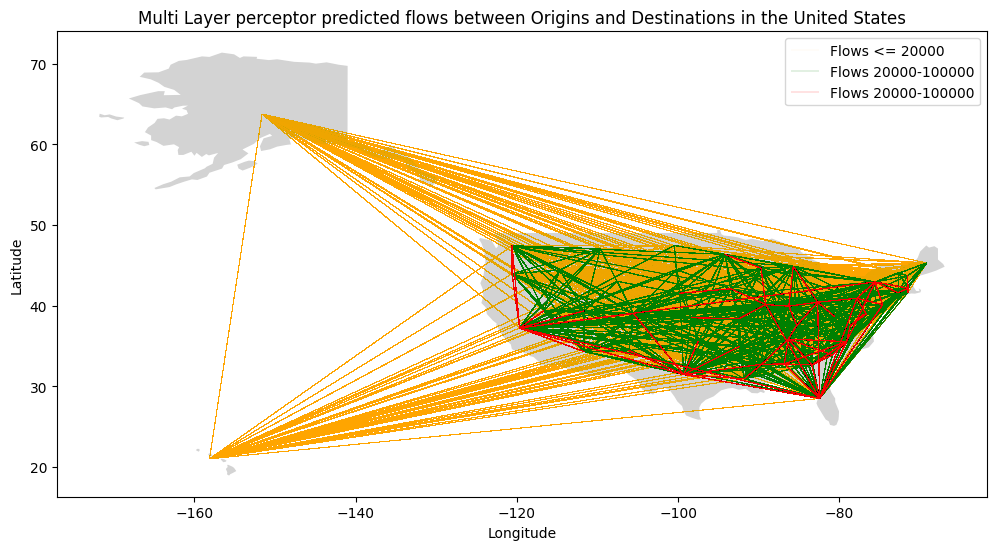

In [28]:
# Load Natural Earth countries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the dataset to get the United States
usa = world[world['name'] == 'United States of America']

# Create point geometries for the origins and destinations (assuming 'testcoord' contains flow data)
gdf_origin = gpd.GeoDataFrame(mlpprediction, geometry=gpd.points_from_xy(testcoord['lng_o'], testcoord['lat_o']))
gdf_destination = gpd.GeoDataFrame(mlpprediction, geometry=gpd.points_from_xy(testcoord['lng_d'], testcoord['lat_d']))

# Create lines representing the flows (LineStrings between origin and destination)
testcoord['geometry'] = [LineString([(x1, y1), (x2, y2)]) for x1, y1, x2, y2 in zip(testcoord['lng_o'], testcoord['lat_o'], testcoord['lng_d'], testcoord['lat_d'])]

# Add flow values to the GeoDataFrame
# Assuming that 'flow_values' is a column in 'testcoord' that represents the flow value between origin and destination
testcoord['flow'] = mlpprediction

# Create the GeoDataFrame with flow geometries
gdf_flows = gpd.GeoDataFrame(testcoord, geometry='geometry')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))  # Define 'ax' here

# Plot the USA map in the background
usa.plot(ax=ax, color='lightgrey')

gdf_flows[gdf_flows['flow'] <= 10000].plot(ax=ax, color='orange', linewidth=0.1, alpha=0.4, label='Flows <= 20000', zorder=1)

# Plot yellow flows (20000-100000)
gdf_flows[(gdf_flows['flow'] > 10000) & (gdf_flows['flow'] <= 100000)].plot(ax=ax, color='Green', linewidth=0.2, alpha=0.8, label='Flows 20000-100000', zorder=2)
gdf_flows[(gdf_flows['flow'] > 100000) & (gdf_flows['flow'] <= 1000000)].plot(ax=ax, color='red', linewidth=0.2, alpha=0.8, label='Flows 20000-100000', zorder=2)

# Plot red flows (100000 and above)
gdf_flows[gdf_flows['flow'] > 1000000].plot(ax=ax, color='yellow', linewidth=0.3, alpha=0.8, label='Flows > 100000', zorder=3)



# Customize the map
plt.title('Multi Layer perceptor predicted flows between Origins and Destinations in the United States')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the map
plt.savefig('/kaggle/working/mlppredictedflows.png', dpi=1200)
plt.show()


In [2]:
pip install geopandas matplotlib shapely fiona pyproj


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install basemap basemap-data


Note: you may need to restart the kernel to use updated packages.


In [34]:
 import pandas as pd
 import networkx as nx
 import matplotlib.pyplot as plt
 from mpl_toolkits.basemap import Basemap as Basemap


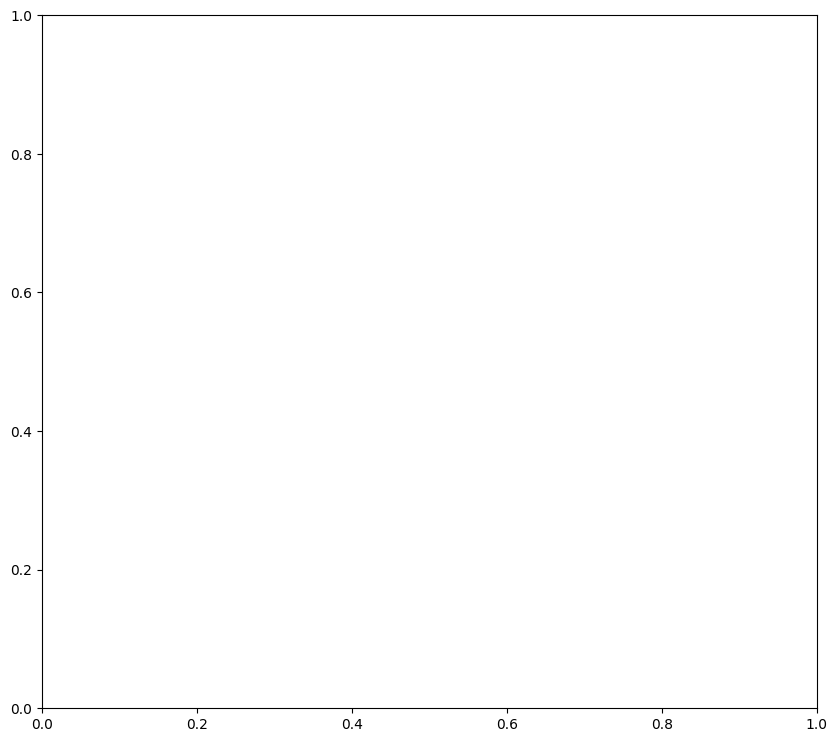

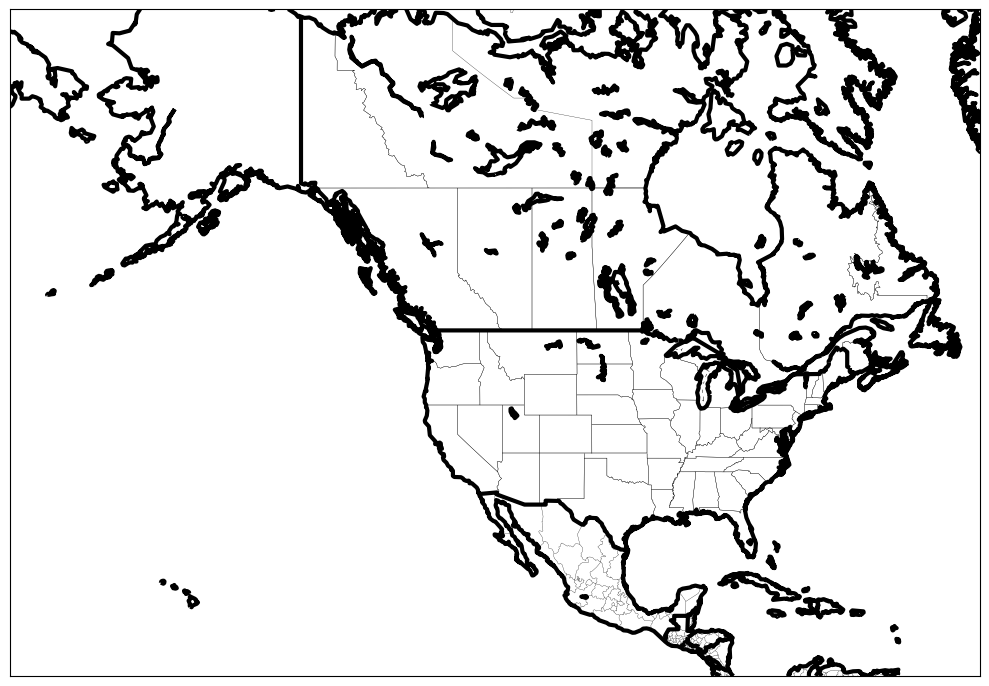

In [47]:
 plt.figure(figsize = (10,9))
 m = Basemap(
         projection='merc',
         llcrnrlon=-180,
         llcrnrlat=10,
         urcrnrlon=-50,
         urcrnrlat=70,
         lat_ts=0,
         resolution='l',
         suppress_ticks=True)

mx, my = (traincoord['lng_o'].values, traincoord['lat_o'].values)
pos = {}
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph.nodes(), node_color = 'r', alpha = 0.8,
                       node_size = [y_train['pop_flows'][s]*3 for s in graph.nodes()])
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g',
                        alpha=0.2, arrows = False)

 plt.figure(figsize = (10,9))
 m = Basemap(
         projection='merc',
         llcrnrlon=-180,
         llcrnrlat=10,
         urcrnrlon=-50,
         urcrnrlat=70,
         lat_ts=0,
         resolution='l',
         suppress_ticks=True)

m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=3)
plt.tight_layout()
plt.show()


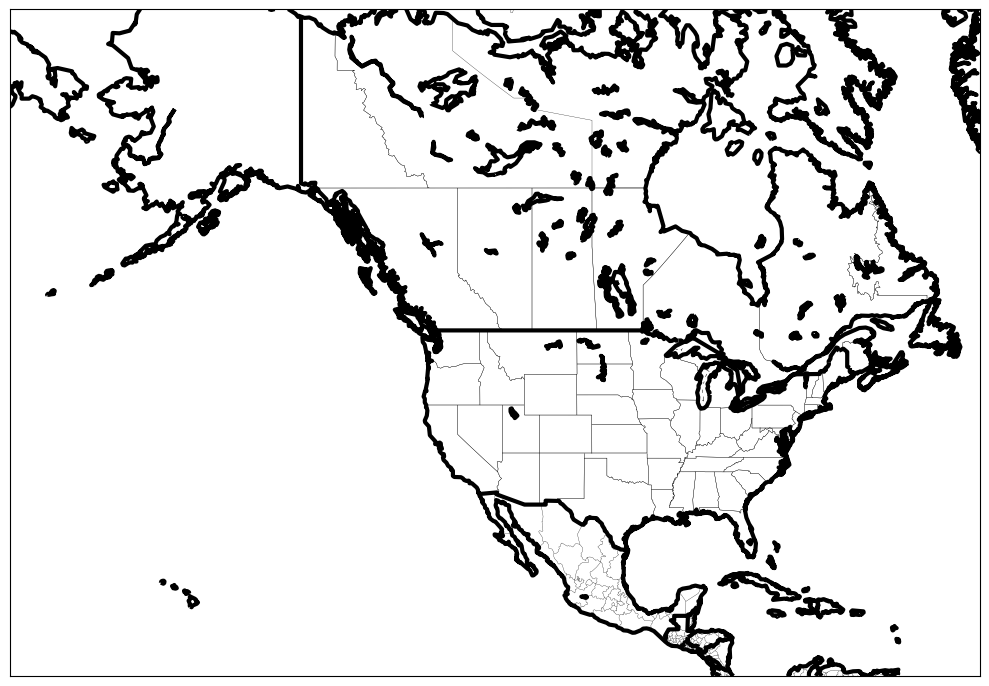

In [55]:
 plt.figure(figsize = (10,9))
 m = Basemap(
         projection='merc',
         llcrnrlon=-180,
         llcrnrlat=10,
         urcrnrlon=-50,
         urcrnrlat=70,
         lat_ts=0,
         resolution='l',
         suppress_ticks=True)
 mx, my = m(traincoord['lng_o'].values, traincoord['lat_o'].values)
 pos = {}
 for count, elem in enumerate (X_train['geoid_o']):
     pos[elem] = (mx[count], my[count])
     
 nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph.nodes(), node_color = 'r', alpha = 0.8,
                       node_size = [y_train[s]*3 for s in graph.nodes()])


 nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph.nodes(), 
                        node_color = 'r', alpha = 0.8, node_size = 100)
 nx.draw_networkx_edges(G = graph, pos = pos, edge_color='g',
                        alpha=0.2, arrows = False)
 m.drawcountries(linewidth = 3)
 m.drawstates(linewidth = 0.2)
 m.drawcoastlines(linewidth=3)
 plt.tight_layout()
 plt.show()


In [18]:
print(y_train.head())

0      200.0
1     3886.0
2     6512.0
3    14921.0
4    13885.0
Name: pop_flows, dtype: float64


In [38]:
plotting = pd.concat([X_train, y_train], axis=1)
print(plotting.head())

   geoid_o  geoid_d      lng_o       lng_d     lat_o      lat_d  \
0        1        2 -86.844521 -151.593422  32.75688  63.742989   
1        1        4 -86.844521 -111.664460  32.75688  34.293095   
2        1        5 -86.844521  -92.439237  32.75688  34.899772   
3        1        6 -86.844521 -119.663846  32.75688  37.215308   
4        1        8 -86.844521 -105.547821  32.75688  38.998532   

   origin_GDP_millions_dollars  destination_GDP_millions_dollars  distance_km  \
0                     222527.4                           52004.2  5559.795327   
1                     222527.4                          352764.7  2306.243061   
2                     222527.4                          126243.8   569.719916   
3                     222527.4                         2901258.9  3021.643753   
4                     222527.4                          373512.4  1821.042320   

   origin_unemployment  ...  police_station_destination  \
0                  3.2  ...                        

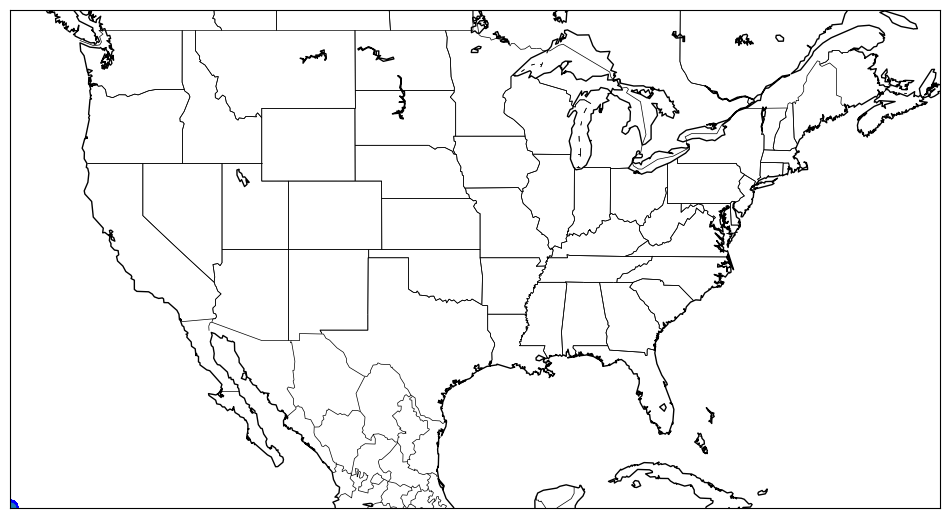

In [29]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Assuming 'plotting' is the merged DataFrame with columns: 'geoid_o', 'geoid_d', 'pop_flows', 'lat_o', 'lng_o', 'lat_d', 'lng_d'
# Create a directed graph from the dataset
graph = nx.from_pandas_edgelist(
    plotting,
    source='geoid_o',
    target='geoid_d',
    edge_attr='pop_flows',
    create_using=nx.DiGraph()
)

# Plot the network
plt.figure(figsize=(12, 10))

# Optional: use Basemap for geographic visualization
m = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='l')
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Check if coordinates are available in the plotting DataFrame
if 'lat_o' in plotting.columns and 'lng_o' in plotting.columns:
    # Create positions for each node using lat/lon for origins
    pos = {
        node: m(
            plotting[plotting['geoid_o'] == node]['lng_o'].values[0],
            plotting[plotting['geoid_o'] == node]['lat_o'].values[0]
        )
        for node in graph.nodes
    }

    # Draw the network with positions based on geographic coordinates
    nx.draw_networkx(
        graph,
        pos=pos,
        node_size=50,
        edge_color='blue',
        alpha=0.5,
        with_labels=False
    )
else:
    # If coordinates are not available, draw the graph without geographic projection
    nx.draw_networkx(
        graph,
        node_size=50,
        edge_color='blue',
        alpha=0.5,
        with_labels=False
    )

# Save the plot
plt.show()


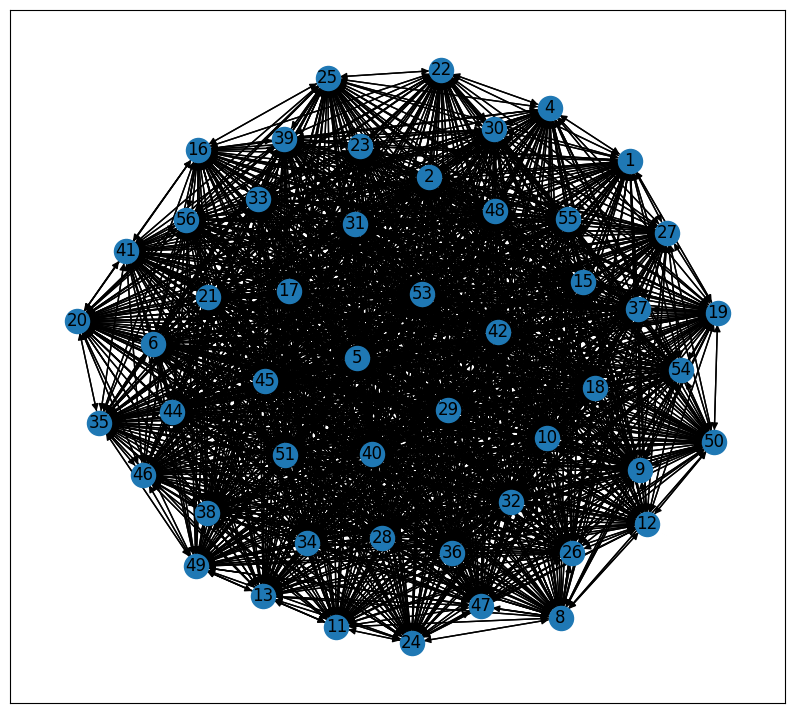

In [30]:
graph = nx.from_pandas_edgelist(
    plotting, 
    source='geoid_o',  # Column for origin node
    target='geoid_d',  # Column for destination node
    edge_attr='pop_flows',  # Column for population flow
    create_using=nx.DiGraph()  # Directed graph
)

# Plot the network
plt.figure(figsize=(10, 9))
nx.draw_networkx(graph)
plt.show()


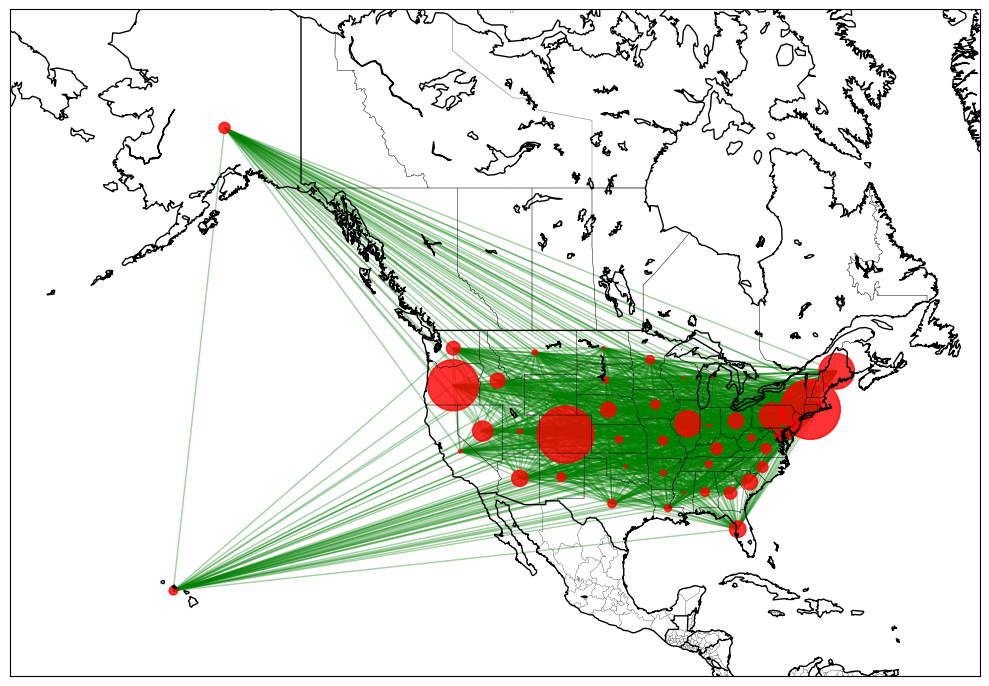

In [89]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Assuming 'plotting' is the merged DataFrame
# Create a directed graph from the population flow data
graph = nx.from_pandas_edgelist(
    plotting, 
    source='geoid_o',  # Column for origin node
    target='geoid_d',  # Column for destination node
    edge_attr='pop_flows',  # Column for population flow
    create_using=nx.DiGraph()  # Directed graph
)

# Plot the network
plt.figure(figsize=(10, 9))

# Create Basemap instance
m = Basemap(
    projection='merc',
    llcrnrlon=-180,
    llcrnrlat=10,
    urcrnrlon=-50,
    urcrnrlat=70,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True
)


# Convert latitude and longitude to x, y coordinates
mx, my = m(plotting['lng_o'].values, plotting['lat_o'].values)

# Create position dictionary mapping each unique node (geoid_o) to its (x, y) coordinates
pos = {}
for count, node in enumerate(plotting['geoid_o']):
    pos[node] = (mx[count], my[count])

# Draw the nodes
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph.nodes(), node_color = 'r', alpha = 0.8,
                       node_size = [plotting['pop_flows'][s]*0.01 for s in graph.nodes()])

# Draw the edges (pop_flows can be used to influence edge color, width, etc.)
nx.draw_networkx_edges(
    graph, pos, 
    edge_color='g', 
    alpha=0.2, 
    arrows=False
)
m.drawcountries(linewidth = 1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
plt.tight_layout()
plt.savefig("/kaggle/working/map_1.png", format = "png", dpi = 300)
plt.show()




In [83]:
plotting1 = pd.concat([X_test, y_test], axis=1)
print(plotting1.head())

         geoid_o  geoid_d     lng_o       lng_d      lat_o      lat_d  \
1245989       13        1 -83.42714  -86.844521  32.638617  32.756880   
1245990       13        2 -83.42714 -151.593422  32.638617  63.742989   
1245991       13        4 -83.42714 -111.664460  32.638617  34.293095   
1245992       13        5 -83.42714  -92.439237  32.638617  34.899772   
1245993       13        6 -83.42714 -119.663846  32.638617  37.215308   

         origin_GDP_millions_dollars  destination_GDP_millions_dollars  \
1245989                     615816.7                          227213.6   
1245990                     615816.7                           50702.9   
1245991                     615816.7                          376719.4   
1245992                     615816.7                          130987.9   
1245993                     615816.7                         3015659.5   

         distance_km  origin_unemployment  ...  police_station_destination  \
1245989   320.703983                  

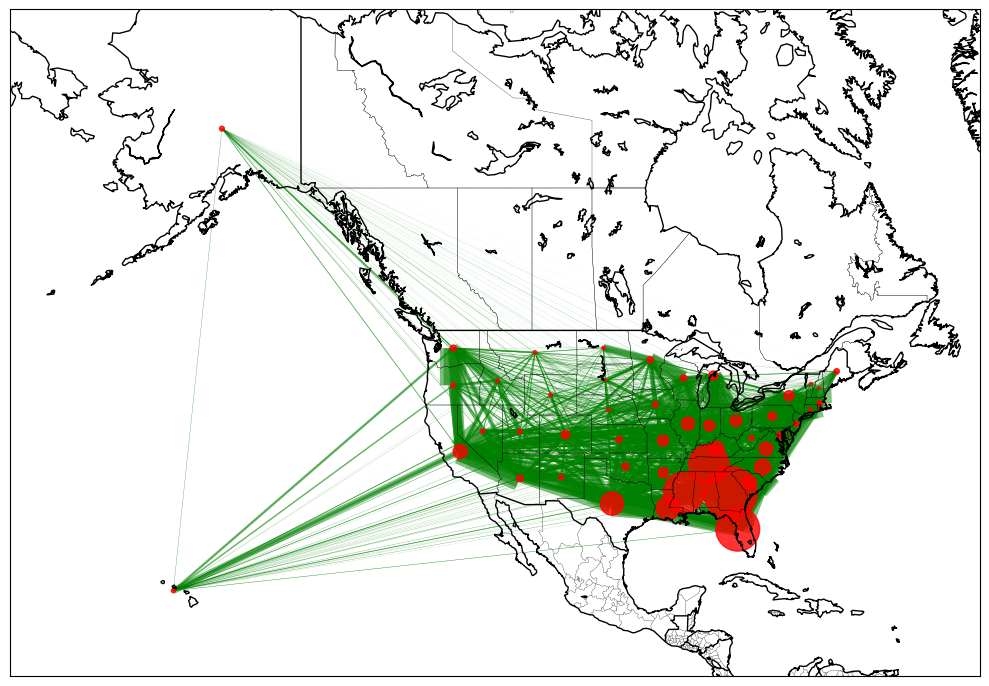

In [138]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Assuming 'plotting1' is the merged DataFrame
# Create a directed graph from the population flow data
graph = nx.from_pandas_edgelist(
    plotting2, 
    source='geoid_o',  # Column for origin node
    target='geoid_d',  # Column for destination node
    edge_attr='pop_flows',  # Column for population flow
    create_using=nx.DiGraph()  # Directed graph
)

# Plot the network
plt.figure(figsize=(10, 9))

# Create Basemap instance
m = Basemap(
    projection='merc',
    llcrnrlon=-180,
    llcrnrlat=10,
    urcrnrlon=-50,
    urcrnrlat=70,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True
)

# Convert latitude and longitude to x, y coordinates for the origin nodes
mx, my = m(plotting1['lng_o'].values, plotting1['lat_o'].values)

# Create position dictionary mapping each unique node (geoid_o) to its (x, y) coordinates
pos = {}
for count, node in enumerate(plotting1['geoid_o']):
    pos[node] = (mx[count], my[count])

# Draw the nodes with size proportional to population flow (scaled by a factor for better visibility)
node_size = []
for node in graph.nodes():
    # Find corresponding population flow for the node (geoid_o)
    flow = plotting1.loc[plotting1['geoid_o'] == node, 'pop_flows'].values
    if len(flow) > 0:
        node_size.append(flow[0] * 0.01)  # Scale by a factor (adjust if needed)
    else:
        node_size.append(10)  # Default size if no flow is found

nx.draw_networkx_nodes(G=graph, pos=pos, nodelist=graph.nodes(), node_color='r', alpha=0.8, node_size=node_size)

# Draw the edges with width proportional to the population flow
edge_width = []
for u, v in graph.edges():
    # Find the corresponding population flow for the edge (from geoid_o to geoid_d)
    flow = plotting1.loc[(plotting1['geoid_o'] == u) & (plotting1['geoid_d'] == v), 'pop_flows'].values
    if len(flow) > 0:
        edge_width.append(flow[0] * 0.0001)  # Scale by a factor (adjust if needed)
    else:
        edge_width.append(1)  # Default width if no flow is found

nx.draw_networkx_edges(graph, pos, width=edge_width, edge_color='g', alpha=0.5, arrows=False)

# Draw the Basemap features
m.drawcountries(linewidth=1)
m.drawstates(linewidth=0.2)
m.drawcoastlines(linewidth=1)

# Display the plot
plt.tight_layout()
plt.savefig("/kaggle/working/map_test.png", format="png", dpi=300)
plt.show()


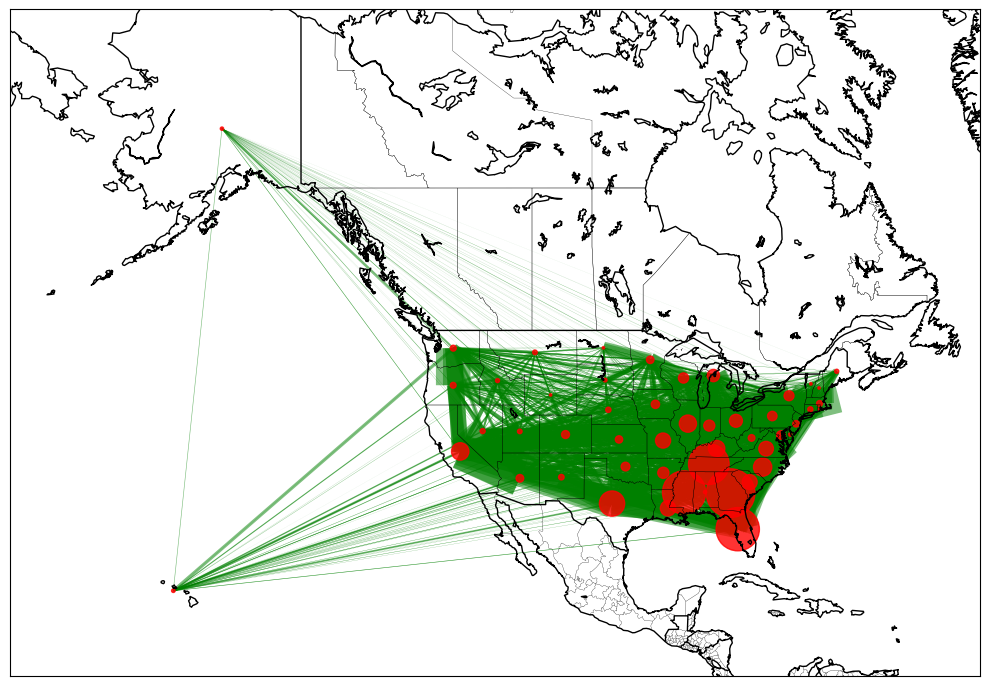

In [139]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Assuming 'plotting1' is the merged DataFrame
# Create a directed graph from the population flow data
graph = nx.from_pandas_edgelist(
    plotting2, 
    source='geoid_o',  # Column for origin node
    target='geoid_d',  # Column for destination node
    edge_attr='pop_flows',  # Column for population flow
    create_using=nx.DiGraph()  # Directed graph
)

# Plot the network
plt.figure(figsize=(10, 9))

# Create Basemap instance
m = Basemap(
    projection='merc',
    llcrnrlon=-180,
    llcrnrlat=10,
    urcrnrlon=-50,
    urcrnrlat=70,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True
)

# Convert latitude and longitude to x, y coordinates for the origin nodes
mx, my = m(plotting2['lng_o'].values, plotting2['lat_o'].values)

# Create position dictionary mapping each unique node (geoid_o) to its (x, y) coordinates
pos = {}
for count, node in enumerate(plotting2['geoid_o']):
    pos[node] = (mx[count], my[count])

# Draw the nodes with size proportional to population flow (scaled by a factor for better visibility)
node_size = []
for node in graph.nodes():
    # Find corresponding population flow for the node (geoid_o)
    flow = plotting2.loc[plotting2['geoid_o'] == node, 'pop_flows'].values
    if len(flow) > 0:
        node_size.append(flow[0] * 0.01)  # Scale by a factor (adjust if needed)
    else:
        node_size.append(10)  # Default size if no flow is found

nx.draw_networkx_nodes(G=graph, pos=pos, nodelist=graph.nodes(), node_color='r', alpha=0.8, node_size=node_size)

# Draw the edges with width proportional to the population flow
edge_width = []
for u, v in graph.edges():
    # Find the corresponding population flow for the edge (from geoid_o to geoid_d)
    flow = plotting2.loc[(plotting2['geoid_o'] == u) & (plotting2['geoid_d'] == v), 'pop_flows'].values
    if len(flow) > 0:
        edge_width.append(flow[0] * 0.0001)  # Scale by a factor (adjust if needed)
    else:
        edge_width.append(1)  # Default width if no flow is found

nx.draw_networkx_edges(graph, pos, width=edge_width, edge_color='g', alpha=0.5, arrows=False)

# Draw the Basemap features
m.drawcountries(linewidth=1)
m.drawstates(linewidth=0.2)
m.drawcoastlines(linewidth=1)

# Display the plot
plt.tight_layout()
plt.savefig("/kaggle/working/map_mlp.png", format="png", dpi=300)
plt.show()


In [112]:
print(mlpprediction.shape)
print(X_test.shape)

(311498, 1)
(311498, 45)


In [133]:

mlpprediction_series = pd.Series(mlpprediction.flatten(), name='pop_flows')
print(mlpprediction_series)
print(X_test.shape)

0         122707.992188
1            603.593079
2           6803.773438
3           6241.998047
4          40768.628906
              ...      
311493       143.368973
311494       373.356842
311495     10289.286133
311496        91.433296
311497       753.374695
Name: pop_flows, Length: 311498, dtype: float32
(311498, 45)


In [135]:
X_test_df = X_test.reset_index(drop=True)
mlpprediction_df = mlpprediction_series.reset_index(drop=True)
plotting2 = pd.concat([X_test_df, mlpprediction_df], axis=1)
print(plotting2.shape)

(311498, 46)


In [145]:
rfprediction_series = pd.Series(rfprediction.flatten(), name='pop_flows')
rfprediction_df = rfprediction_series.reset_index(drop=True)
plotting3 = pd.concat([X_test_df, rfprediction_df], axis=1)
print(plotting3.shape)

(311498, 46)


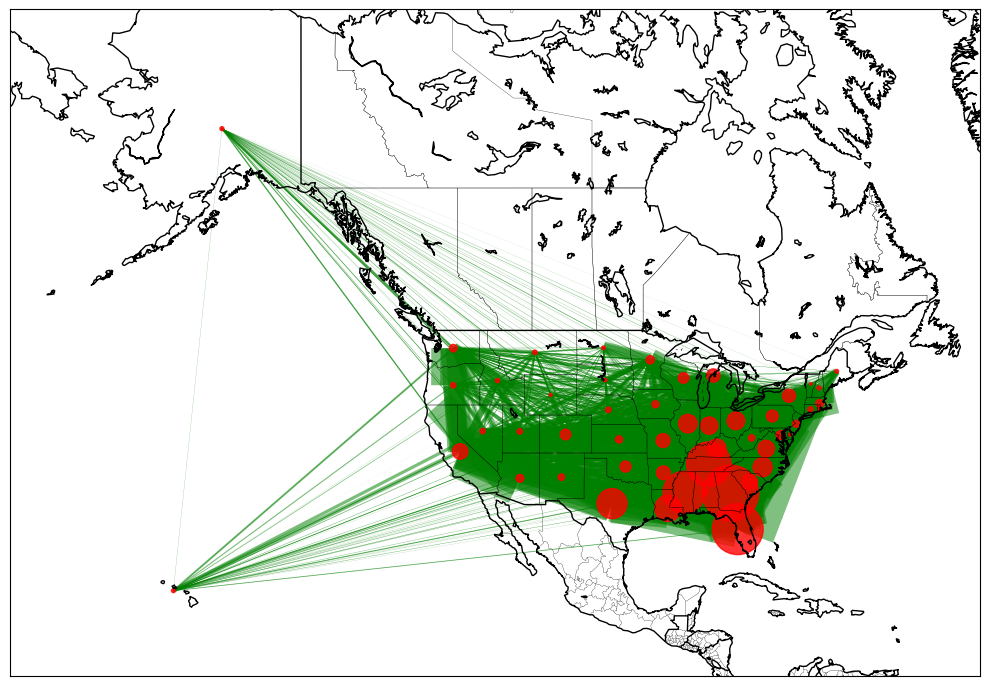

In [146]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Assuming 'plotting1' is the merged DataFrame
# Create a directed graph from the population flow data
graph = nx.from_pandas_edgelist(
    plotting2, 
    source='geoid_o',  # Column for origin node
    target='geoid_d',  # Column for destination node
    edge_attr='pop_flows',  # Column for population flow
    create_using=nx.DiGraph()  # Directed graph
)

# Plot the network
plt.figure(figsize=(10, 9))

# Create Basemap instance
m = Basemap(
    projection='merc',
    llcrnrlon=-180,
    llcrnrlat=10,
    urcrnrlon=-50,
    urcrnrlat=70,
    lat_ts=0,
    resolution='l',
    suppress_ticks=True
)

# Convert latitude and longitude to x, y coordinates for the origin nodes
mx, my = m(plotting3['lng_o'].values, plotting3['lat_o'].values)

# Create position dictionary mapping each unique node (geoid_o) to its (x, y) coordinates
pos = {}
for count, node in enumerate(plotting3['geoid_o']):
    pos[node] = (mx[count], my[count])

# Draw the nodes with size proportional to population flow (scaled by a factor for better visibility)
node_size = []
for node in graph.nodes():
    # Find corresponding population flow for the node (geoid_o)
    flow = plotting3.loc[plotting3['geoid_o'] == node, 'pop_flows'].values
    if len(flow) > 0:
        node_size.append(flow[0] * 0.01)  # Scale by a factor (adjust if needed)
    else:
        node_size.append(10)  # Default size if no flow is found

nx.draw_networkx_nodes(G=graph, pos=pos, nodelist=graph.nodes(), node_color='r', alpha=0.8, node_size=node_size)

# Draw the edges with width proportional to the population flow
edge_width = []
for u, v in graph.edges():
    # Find the corresponding population flow for the edge (from geoid_o to geoid_d)
    flow = plotting3.loc[(plotting3['geoid_o'] == u) & (plotting3['geoid_d'] == v), 'pop_flows'].values
    if len(flow) > 0:
        edge_width.append(flow[0] * 0.0001)  # Scale by a factor (adjust if needed)
    else:
        edge_width.append(1)  # Default width if no flow is found

nx.draw_networkx_edges(graph, pos, width=edge_width, edge_color='g', alpha=0.5, arrows=False)

# Draw the Basemap features
m.drawcountries(linewidth=1)
m.drawstates(linewidth=0.2)
m.drawcoastlines(linewidth=1)

# Display the plot
plt.tight_layout()
plt.savefig("/kaggle/working/map_rf.png", format="png", dpi=300)
plt.show()
